In [77]:
%pip install ipywidgets matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, Layout
from scipy.stats import norm

In [79]:
# Definition of Black-Scholes function

def black_scholes(S, X, T: int = 1, option_type: str = 'c', r: int = 0, sigma: int = 0, MC = True) -> float:
    '''
    Arguments:
    S           -- intial spot price of the underlying security (before MC)
    X           -- option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- risk-free interest rate 
    sigma       -- returns volatility of the underlying security
    option_type -- the option type, either 'c' for 'call' or 'p' for 'put'
    
    Returns: option value [float]
    '''

    np.random.seed(1)

    if MC:

        def sim(S0: int, r = r, sigma = sigma, T = T, time_step: int = 252, path_num: int = 10000):
            # Time step size, default T to number of trading days in a year
            dt = T / time_step  

            # Generate random normal variables for both paths
            Z = np.random.standard_normal((time_step, path_num))
            # Antithetic variates
            Z_antithetic = -Z  

            # Underlying security price paths (Geometric Brownian Motion with Antithetic Variates)
            stock_paths = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z, axis=0))
            stock_paths_antithetic = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z_antithetic, axis=0))

            # Combine paths from original and antithetic samples
            combined_paths = (stock_paths[-1, :] + stock_paths_antithetic[-1, :]) / 2

            # Control variate for the exact expected underlying security price
            control_variate = np.mean(combined_paths) - np.mean(stock_paths[-1, :]) + S0 * np.exp(r * T)

            # Return the adjusted MC estimate using control variates and antithetic variates
            return control_variate

        # Run the simulation if MC is True
        S = sim(S)


    # Auxiliary function for d_one & d_two risk-adjusted probability
    d1_fn = lambda S, X, T, r, sigma: (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2_fn = lambda d1, T, sigma: d1 - sigma * np.sqrt(T)

    d_one = d1_fn(S, X, T, r, sigma)
    d_two = d2_fn(d_one, T, sigma)

    if option_type == 'c': 
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'p': 
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type must be either 'call' or 'put'.")

In [80]:
def plot_black_scholes(Spot, Strike, Time, Type, IR, Vol, X_Axis):
    # Define ranges for the parameters
    param_ranges = {
        'Volatility': np.arange(0.05, 1.0, 0.05),
        'Time to Maturity': np.linspace(0.1, 2.0, 20),
        'Spot Price': np.linspace(50, 300, 20),
        'Strike Price': np.linspace(50, 300, 20),
        'Interest Rate': np.linspace(0.0, 0.1, 20)
    }
    
    # Select the x-axis data based on the X_Axis choice
    x_data = param_ranges[X_Axis]
    
    # Calculate option prices for each value on the x-axis
    prices = [black_scholes(
                Spot if X_Axis != 'Spot Price' else x,
                Strike if X_Axis != 'Strike Price' else x,
                Time if X_Axis != 'Time to Maturity' else x,
                Type, 
                IR if X_Axis != 'Interest Rate' else x,
                Vol if X_Axis != 'Volatility' else x
              ) 
              for x in x_data]
    
    # Clear the previous plot and create a new one
    plt.figure(figsize=(10, 6))

    # Plot using seaborn
    sns.lineplot(x=x_data, y=prices)
    plt.xlabel(X_Axis)
    plt.ylabel('Option Price'), plt.ylim(0,300)
    plt.title(f'Black-Scholes Option Pricing with {X_Axis} as X-Axis')
    plt.grid(True)
    plt.show()

widget_layout = Layout(width='300px', height='30px')


interact(plot_black_scholes,
         Spot=IntSlider(min=50, max=300, step=10, value=200, description='Spot Price', layout=widget_layout),
         Strike=IntSlider(min=50, max=300, step=10, value=120, description='Strike Price', layout=widget_layout),
         Time=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.5, description='Time to Maturity', layout=widget_layout),
         Type=Dropdown(options=[('Call','c'),('Put','p')], value='c', description='Option Type', layout=widget_layout),
         IR=FloatSlider(min=0.0, max=0.1, step=0.01, value=0.02, description='Interest Rate', layout=widget_layout),
         Vol=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.5, description='Volatility', layout=widget_layout),
         X_Axis=Dropdown(options=['Volatility', 'Time to Maturity', 'Spot Price', 'Strike Price', 'Interest Rate'], 
                         value='Volatility', description='X-Axis', layout=widget_layout)
)

interactive(children=(IntSlider(value=200, description='Spot Price', layout=Layout(height='30px', width='300px…

<function __main__.plot_black_scholes(Spot, Strike, Time, Type, IR, Vol, X_Axis)>

In [81]:
# Example of Spot vs Volatility wrt. Gamma  

def gamma(S, X, T, option_type: 'str', r = 0, sigma=0):
    '''
    Arguments:
    S           -- current spot price of the underlying security
    X           -- option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- risk-free interest rate 
    sigma       -- returns volatility of the underlying security
    option_type -- the option type, either 'call' or 'put'
    
    Returns: gamma of option (second derivative of option price wrt S) [float]
    '''
    d1_fn = lambda S, X, T, r, sigma: (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2_fn = lambda d1, T, sigma: d1 - sigma * np.sqrt(T)

    if option_type == 'c':
        return norm.pdf(d1_fn(S, X, T, r, sigma))/(S*sigma*T)
    elif option_type == 'p':
        return norm.pdf(d2_fn(S, X, T, r, sigma))/(S*sigma*T)
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is neither 'c' for 'call' or 'p' for 'put'.")

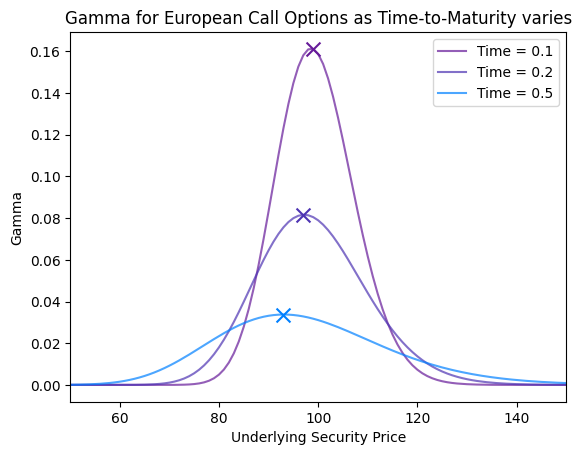

In [82]:
# Static gamma plot

def plot_gamma():
    
    params_dict = {
        'S': np.arange(10, 200, 1),
        'X': 100,
        'T': np.array([0.1, 0.2, 0.5]),
        'option_type': 'c',
        'r': 0.05,
        'sigma': 0.25,
    }

    _, ax = plt.subplots()

    for time in params_dict['T']:
        # Copy the params dict but with only the single value under time key
        temp_params_dict = params_dict.copy()
        temp_params_dict['T'] = time
        df = pd.DataFrame({'Gamma': gamma(*temp_params_dict.values()),
                           'Spot': params_dict['S']})

        # Plot the line for the Gamma
        df.plot('Spot', 'Gamma', kind='line',
                color=(0.5-time, time, 0.5+time), label=f'Time = {time}',
                ax=ax, alpha=0.7, xlim=(50, 150))

        # Find the maximum Gamma and corresponding spot price
        max_gamma_idx = df['Gamma'].idxmax()
        max_gamma_spot = df.loc[max_gamma_idx, 'Spot']
        max_gamma_value = df.loc[max_gamma_idx, 'Gamma']

        # Plot a cross at the peak
        ax.scatter(max_gamma_spot, max_gamma_value, color=(0.5-time, time, 0.5+time), marker='x', s=100, zorder=5)

    ax.set(xlabel='Underlying Security Price', ylabel='Gamma',
           title='Gamma for European Call Options as Time-to-Maturity varies')
    plt.show()

plot_gamma()


In [83]:
# Interactive Gamma Plot

def interactive_plot_gamma(T: int = 0.2, sigma: int = 0.25, r: int = 0.05):
    params_dict = {
        'S': np.arange(10, 200, 1),
        'X': 100,
        'T': T,
        'option_type': 'c',
        'r': r,
        'sigma': sigma,
    }

    _, ax = plt.subplots()

    df = pd.DataFrame({
        'Gamma': gamma(params_dict['S'], params_dict['X'], params_dict['T'], params_dict['option_type'], params_dict['r'], params_dict['sigma']),
        'Spot': params_dict['S']
    })

    # Plot the Gamma curve
    df.plot('Spot', 'Gamma', kind='line', color='purple', label=f'Time = {params_dict["T"]}', ax=ax, alpha=0.7, xlim=(50, 150))

    # Find and plot the maximum Gamma point
    max_idx = df['Gamma'].idxmax()
    ax.scatter(df.loc[max_idx, 'Spot'], df.loc[max_idx, 'Gamma'], color='blue', marker='x', s=100, zorder=5)

    ax.set(xlabel='Underlying Security Price', ylabel='Gamma',
           title='Gamma for European Call Options')
    plt.show()

# Create interactive sliders for T (time-to-maturity), sigma (volatility), and r (risk-free rate)
interact(interactive_plot_gamma, 
         T=FloatSlider(value=0.2, min=0.05, max=1.0, step=0.05, description='Time to Maturity'),
         sigma=FloatSlider(value=0.25, min=0.1, max=0.5, step=0.01, description='Volatility'),
         r=FloatSlider(value=0.05, min=0.0, max=0.1, step=0.005, description='Interest Rate'));


interactive(children=(FloatSlider(value=0.2, description='Time to Maturity', max=1.0, min=0.05, step=0.05), Fl…